In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import pickle
import pingouin as pg


### Step 1. Read the data

In [ ]:
eoi = ['EYEOPEN', 'IN', 'QF', 'SPEAK', 'TYPE', 'READ', 'LISTEN', ]
conditions = ['IN', 'QF', 'QS', 'RJ', 'READ', 'LISTEN', 'SPEAK', 'TYPE']
baseline = ['EYEOPEN', 'EYECLOSE']
info_cols = ['PID', 'Topic', 'stage']
chs = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]
bands = ['theta', 'alpha', 'beta', 'lowgamma']
bands_names = ['Theta (4-8Hz)', 'Alpha (8-13Hz)', 'Beta (13-25Hz)', 'Lowgamma (25-40Hz)']
data_remove = pickle.load(open('data_to_remove.pkl', 'rb'))
data_remove

Format the data

In [ ]:
def remove_data(df):
    data_remove1 = [('PA11', '353.0'), ('PA13', '419.0'), ('PA23', '433.0'), \
                   ('PA23', '725.0'), ('PA26', '433.0'), ('PA26', '448.0'), ('PA26', '416.0')]
    data_remove2 = [('PA11', 353), ('PA13', 419), ('PA23', 433), ('PA23', 725), ('PA26', 433), ('PA26', 448), ('PA26', 416)]
    print('Data to Remove', data_remove1)
    print('-> Before', df.shape)
    nums_drop = 0
    for (pid, tid) in data_remove1 + data_remove2:
        nums_drop += df[(df.PID == pid) & (df.Topic == tid)].shape[0]
        df.drop(df[(df.PID == pid) & (df.Topic == tid)].index, inplace=True) 
    plist = df.PID.unique()
    print(nums_drop, 'should droped')
    print('--> after remove unwanted data', df.shape, 'from', len(plist), 'Participants')
    print(plist)
    return df, plist
    
def load_data(file):
    df = pd.read_csv(file, index_col=0).reset_index(drop=True)
    df = df[~df.PID.isin(['PA2', 'PA3', 'PA4'])]
    df.replace({'SR': 'RJ'}, inplace=True)
    df, plist = remove_data(df)
    df = df[df.stage.isin(conditions+baseline)]
    specfeats = [f for f in df.columns.values if f.__contains__('bandPower_PSD_norm')\
            or f.__contains__('bandPower:PSD_norm')]
    df = df[info_cols+specfeats]

    
    data = []
    for (pid, topic, stage) in df[['PID', 'Topic', 'stage']].value_counts().index:
        tt = df[(df.PID == pid) & (df.Topic == topic) & (df.stage == stage)]
        t = tt.mean(numeric_only=True).to_frame().transpose()
        t['PID'] = pid
        t['Topic'] = topic
        t['stage'] = stage
        data.append(t)
        
    df = pd.concat(data)
    df = df.reset_index(drop=True)
    print('--> Final Loaded Data:', df.shape)
    print(df.stage.value_counts())
    return df

In [ ]:
data = load_data('data for analysis/EEG_features(2-1).csv')
data

In [ ]:
staistic = data[data.stage.isin(eoi)][['PID', 'Topic', 'stage']].value_counts().reset_index()
staistic

In [ ]:
staistic[['count', 'stage']].groupby('stage').sum()

In [ ]:
data.stage.value_counts()

In [ ]:
## format the data
info = ['PID', 'stage', 'Topic']
features = [c for c in data.columns if c.__contains__('norm') and (c.__contains__(bands[0]) \
            or c.__contains__(bands[1]) or c.__contains__(bands[2]) or c.__contains__(bands[3]))]
print(len(features), 'EEG features')
data = data[features+info]
data.rename(columns={f: '_'.join(f.split('_')[-2:]) for f in features}, inplace=True)
data.head(3)

In [ ]:
freq_features = {}
for fq in bands:
    freq_features[fq] = [c for c in data.columns if c.__contains__(fq) and c.split('_')[0] in chs]
print('Get the feature names for each band:', freq_features)

### Step 2. Conduct Statistical Testing

In [10]:
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.normality(data=data[data.stage.isin(eoi)], dv=depvar, group='stage')
        if stats['normal'].values[0]: tcnt +=1
        else: fcnt += 1
    print(f'Check Normality for band [{band}]: {tcnt/(tcnt+fcnt):.2f}, {tcnt} channels normal distribution, {fcnt} not.')
print('-'*20)
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.homoscedasticity(data=data[data.stage.isin(eoi)], dv=depvar, group='stage')
        if stats['equal_var'].values[0]: tcnt +=1
        else: fcnt += 1
    print(f'Check Homoscedasticity for band [{band}]: {tcnt/(tcnt+fcnt):.2f}, {tcnt} channels equal variance, {fcnt} have not.')

Check Normality for band [theta]: 0.64, 9 channels normal distribution, 5 not.
Check Normality for band [alpha]: 0.14, 2 channels normal distribution, 12 not.
Check Normality for band [beta]: 0.36, 5 channels normal distribution, 9 not.
Check Normality for band [lowgamma]: 0.21, 3 channels normal distribution, 11 not.
--------------------
Check Homoscedasticity for band [theta]: 0.14, 2 channels equal variance, 12 have not.
Check Homoscedasticity for band [alpha]: 0.00, 0 channels equal variance, 14 have not.
Check Homoscedasticity for band [beta]: 0.29, 4 channels equal variance, 10 have not.
Check Homoscedasticity for band [lowgamma]: 0.36, 5 channels equal variance, 9 have not.


In [11]:
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.sphericity(data=data[data.stage.isin(eoi)], dv=depvar, within='stage', subject='PID')
        if stats.spher: tcnt +=1
        else: fcnt += 1
    print(f'Check sphericityity for band [{band}]: {tcnt} channels have sphericity property, {fcnt} have not.')

Check sphericityity for band [theta]: 14 channels have sphericity property, 0 have not.


/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig

Check sphericityity for band [alpha]: 14 channels have sphericity property, 0 have not.
Check sphericityity for band [beta]: 14 channels have sphericity property, 0 have not.
Check sphericityity for band [lowgamma]: 14 channels have sphericity property, 0 have not.


In [ ]:
def compute_RMf(df, depvars, within, parametric=True):
    results = []
    for depvar in depvars:
        ch = depvar.split('_')[0]
        if not parametric:
            res = pg.friedman(data=df, dv=depvar, subject='PID', within=within, method='f')
        else:
            res = pg.rm_anova(data=df, dv=depvar, subject='PID', within=within,correction=True)
        res['ch'] = ch
        results.append(res)
    results = pd.concat(results)
    results.reset_index(drop=True, inplace=True)
    return results


def compute_pairwise(df, depvars, within, parametric=True):
    results = []
    for depvar in depvars:
        ch = depvar.split('_')[0]
        res = pg.pairwise_tests(data=df, dv=depvar, parametric=parametric, padjust='bonf',
                  subject='PID', within=within, correction=True)
        res['ch'] = ch
        results.append(res)
    results = pd.concat(results)
    results.reset_index(drop=True, inplace=True)
    return results

opath= 'Standard-10-20-Cap14.locs'
mont=mne.channels.read_custom_montage(opath)

#### compute on the 6 stages + EYEOPEN

In [ ]:
cond6 = eoi
print(cond6)
dd6 = data[data.stage.isin(cond6)]
print(dd6.stage.value_counts())

In [ ]:
fstats_stage = {}
for (band, ffs) in freq_features.items():
    res = compute_RMf(dd6, ffs, 'stage', False)
    fstats_stage[band] = res
print(fstats_stage['alpha'])    

pos_stage = {}
for key, val in fstats_stage.items():
    sen = val[val['p-unc'] < 0.001].ch.values
    pos_stage[key] = sen
print(pos_stage)

In [18]:
stats_results = []
for k, d in fstats_stage.items():
    d['band'] = k
    stats_results.append(d)
stats_results = pd.concat(stats_results)
stats_results.to_csv('../results/stats_results_6stages.csv', index=False)
stats_results

,Source,W,ddof1,ddof2,F,p-unc,ch,band
0,stage,0.075760,5.931034,166.068966,2.295166,3.790562e-02,AF3,theta
1,stage,0.155512,5.931034,166.068966,5.156190,7.433058e-05,F7,theta
2,stage,0.142687,5.931034,166.068966,4.660194,2.223488e-04,F3,theta
3,stage,0.094530,5.931034,166.068966,2.923178,1.004518e-02,FC5,theta
4,stage,0.211823,5.931034,166.068966,7.525000,4.258267e-07,T7,theta
5,stage,0.310005,5.931034,166.068966,12.580010,1.385566e-11,P7,theta
6,stage,0.300578,5.931034,166.068966,12.033030,4.033382e-11,O1,theta
7,stage,0.286479,5.931034,166.068966,11.241995,1.932012e-10,O2,theta
8,stage,0.261933,5.931034,166.068966,9.936939,2.707289e-09,P8,theta
9,stage,0.158825,5.931034,166.068966,5.286753,5.572964e-05,T8,theta


##### plot

In [19]:
vmax = max([f['F'].max() for f in fstats_stage.values()])
print(vmax)
vlim = (0, 55)

51.939864209505345


In [20]:
stats_results[stats_results.F == stats_results.F.max()]

,Source,W,ddof1,ddof2,F,p-unc,ch,band
5,stage,0.649737,5.931034,166.068966,51.939864,2.025663e-35,P7,alpha


In [21]:
fstats_stage['alpha']

,Source,W,ddof1,ddof2,F,p-unc,ch,band
0,stage,0.279429,5.931034,166.068966,10.858086,4.170268e-10,AF3,alpha
1,stage,0.394004,5.931034,166.068966,18.204905,4.551791e-16,F7,alpha
2,stage,0.431969,5.931034,166.068966,21.293062,2.519806e-18,F3,alpha
3,stage,0.441821,5.931034,166.068966,22.163116,6.153733e-19,FC5,alpha
4,stage,0.535502,5.931034,166.068966,32.280124,2.108529e-25,T7,alpha
5,stage,0.649737,5.931034,166.068966,51.939864,2.025663e-35,P7,alpha
6,stage,0.621029,5.931034,166.068966,45.884357,1.286474e-32,O1,alpha
7,stage,0.488194,5.931034,166.068966,26.708264,5.551073e-22,O2,alpha
8,stage,0.572872,5.931034,166.068966,37.554186,2.268238e-28,P8,alpha
9,stage,0.554782,5.931034,166.068966,34.890500,6.679951e-27,T8,alpha


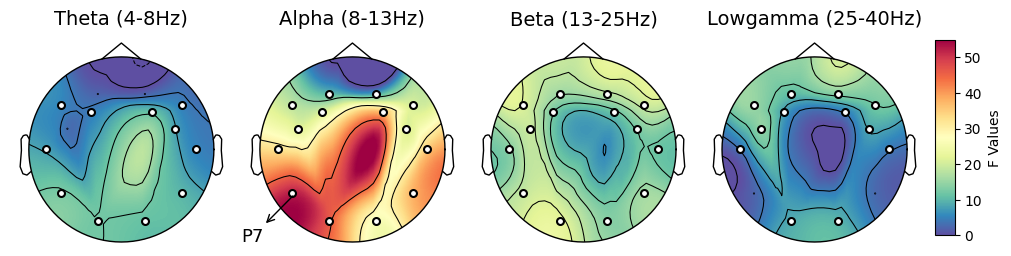

In [27]:
OUTPUT = 1

fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout='constrained')

for n, (band, vals) in enumerate(fstats_stage.items()):
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['F'].values)
    highlight_channels = pos_stage[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=14)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('F Values')

dig_positions = mont.get_positions()['ch_pos']
p7_position = dig_positions['P7']

axes[1].annotate(
    'P7',
    xy=(p7_position[0]+0.002, p7_position[1]-0.002), xycoords='data',
    xytext=(0, 0), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='<-'),
    fontsize=13, color='black'
)

if OUTPUT:
    plt.savefig(f'images/EEG_FRIEDMAN_topo(6-p.001).pdf', bbox_inches='tight')
plt.show()

#### Posthoc

In [22]:
posthoc = {}
for (band, ffs) in freq_features.items():
    res = compute_pairwise(dd6, ffs, 'stage', False)
    posthoc[band] = res
res

posthoc['alpha']

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges,ch
0,stage,EYEOPEN,IN,True,False,157.0,two-sided,1.976249e-01,1.000000,bonf,-0.260012,AF3
1,stage,EYEOPEN,LISTEN,True,False,109.0,two-sided,1.788491e-02,0.375583,bonf,-0.441991,AF3
2,stage,EYEOPEN,QF,True,False,113.0,two-sided,2.290834e-02,0.481075,bonf,-0.458173,AF3
3,stage,EYEOPEN,READ,True,False,150.0,two-sided,1.493656e-01,1.000000,bonf,-0.345227,AF3
4,stage,EYEOPEN,SPEAK,True,False,87.0,two-sided,3.798388e-03,0.079766,bonf,0.569872,AF3
...,...,...,...,...,...,...,...,...,...,...,...,...
289,stage,QF,SPEAK,True,False,8.0,two-sided,9.313226e-08,0.000002,bonf,0.815596,AF4
290,stage,QF,TYPE,True,False,35.0,two-sided,1.595169e-05,0.000335,bonf,0.838738,AF4
291,stage,READ,SPEAK,True,False,47.0,two-sided,7.731095e-05,0.001624,bonf,0.741009,AF4
292,stage,READ,TYPE,True,False,51.0,two-sided,1.240671e-04,0.002605,bonf,0.784703,AF4


In [23]:
postdoc_results = []
for k, d in posthoc.items():
    d['band'] = k
    postdoc_results.append(d)
postdoc_results = pd.concat(postdoc_results)
postdoc_results

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges,ch,band
0,stage,EYEOPEN,IN,True,False,198.0,two-sided,0.685574,1.000000,bonf,-0.045967,AF3,theta
1,stage,EYEOPEN,LISTEN,True,False,200.0,two-sided,0.717209,1.000000,bonf,0.069189,AF3,theta
2,stage,EYEOPEN,QF,True,False,213.0,two-sided,0.932128,1.000000,bonf,-0.015200,AF3,theta
3,stage,EYEOPEN,READ,True,False,169.0,two-sided,0.304193,1.000000,bonf,-0.140307,AF3,theta
4,stage,EYEOPEN,SPEAK,True,False,136.0,two-sided,0.079760,1.000000,bonf,0.370521,AF3,theta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,stage,QF,SPEAK,True,False,28.0,two-sided,0.000006,0.000116,bonf,0.723152,AF4,lowgamma
290,stage,QF,TYPE,True,False,51.0,two-sided,0.000124,0.002605,bonf,0.610701,AF4,lowgamma
291,stage,READ,SPEAK,True,False,24.0,two-sided,0.000003,0.000060,bonf,0.770491,AF4,lowgamma
292,stage,READ,TYPE,True,False,36.0,two-sided,0.000018,0.000386,bonf,0.655030,AF4,lowgamma


In [24]:
postdoc_results.to_csv('../results/postdoc_results_6stages.csv', index=False)

##### EYEOPEN VS IN VS RJ-READ

In [25]:
fstats3 = {}
for (band, ffs) in freq_features.items():
    res = compute_RMf(data[data.stage.isin(['EYEOPEN', 'IN', 'READ'])], \
                      ffs, 'stage', False)
    fstats3[band] = res
print(fstats3['alpha'])    

pos3 = {}
for key, val in fstats3.items():
    sen = val[val['p-unc'] < 0.001].ch.values
    pos3[key] = sen
print(pos3)

   Source         W     ddof1      ddof2          F     p-unc   ch
0   stage  0.076100  1.931034  54.068966   2.306306  0.111096  AF3
1   stage  0.051130  1.931034  54.068966   1.508772  0.230633   F7
2   stage  0.171225  1.931034  54.068966   5.784792  0.005760   F3
3   stage  0.046373  1.931034  54.068966   1.361596  0.264589  FC5
4   stage  0.250892  1.931034  54.068966   9.377778  0.000371   T7
5   stage  0.185493  1.931034  54.068966   6.376642  0.003594   P7
6   stage  0.250892  1.931034  54.068966   9.377778  0.000371   O1
7   stage  0.272295  1.931034  54.068966  10.477124  0.000169   O2
8   stage  0.367420  1.931034  54.068966  16.263158  0.000004   P8
9   stage  0.322235  1.931034  54.068966  13.312281  0.000025   T8
10  stage  0.093936  1.931034  54.068966   2.902887  0.065235  FC6
11  stage  0.286564  1.931034  54.068966  11.246667  0.000099   F4
12  stage  0.014269  1.931034  54.068966   0.405308  0.661628   F8
13  stage  0.015458  1.931034  54.068966   0.439614  0.639642 

In [30]:
stats3 = []
for k, d in fstats3.items():
    d['band'] = k
    stats3.append(d)
stats3 = pd.concat(stats3)
stats3.to_csv('../results/stats_results_ECINREAD.csv', index=False)

In [27]:
vmax = max([f['F'].max() for f in fstats3.values()])
vmin = min([f['F'].min() for f in fstats3.values()])
print(vmax, vmin)
vlim = (0, 20)

16.263157894736842 0.03333333333333333


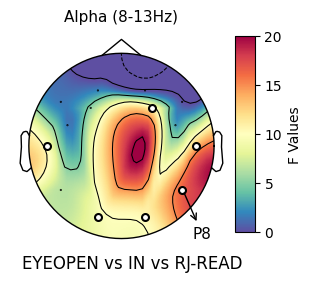

In [28]:
OUTPUT = 1

fig, axes = plt.subplots(1, figsize=(3, 4), layout='constrained')

band = 'alpha'
vals = fstats3[band]
info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
info.set_montage(mont)
f_values = np.array(vals['F'].values)
highlight_channels = pos3[band]
mask = np.array([ch in highlight_channels for ch in info['ch_names']])

im, _ = mne.viz.plot_topomap(f_values, info, axes=axes, size=5, res=32,
                     show=False, sphere=0.12, sensors=True, contours=5, 
                     vlim=vlim, cmap='Spectral_r',
                    mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
axes.set_title(bands_names[1],fontsize=11)

cbar = fig.colorbar(im, ax=axes, drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('F Values')

dig_positions = mont.get_positions()['ch_pos']
p8_position = dig_positions['P8']

axes.annotate(
    'P8',
    xy=(p8_position[0]+0.003, p8_position[1]-0.002), xycoords='data',
    xytext=(0.82, 0), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='<-'),
    fontsize=11, color='black'
)
fig.suptitle('EYEOPEN vs IN vs RJ-READ', x=0.42, y=0.2)

if OUTPUT:
    plt.savefig(f'images/EEG_EOINREAD(p.001).pdf', bbox_inches='tight')
plt.show()

READ VS LISTEN

In [29]:
pos1 = {}
ss1 = {}
for key, val in posthoc.items():
    val = val[((val['A'] == 'LISTEN') & (val['B'] == 'READ')) | \
    ((val['B'] == 'LISTEN') & (val['A'] == 'READ')) ]
    sen = val[val['p-corr'] < 0.05].ch.values
    pos1[key] = sen
    ss1[key] = val
print(pos1)
ss1

{'theta': array(['F7', 'P7', 'O1', 'O2', 'P8', 'FC6', 'F4'], dtype=object), 'alpha': array(['FC5', 'P7', 'O1', 'O2'], dtype=object), 'beta': array([], dtype=object), 'lowgamma': array([], dtype=object)}


{'theta':     Contrast       A     B  Paired  Parametric  W-val alternative  \
 12     stage  LISTEN  READ    True       False   96.0   two-sided   
 33     stage  LISTEN  READ    True       False   80.0   two-sided   
 54     stage  LISTEN  READ    True       False   83.0   two-sided   
 75     stage  LISTEN  READ    True       False  151.0   two-sided   
 96     stage  LISTEN  READ    True       False   86.0   two-sided   
 117    stage  LISTEN  READ    True       False   57.0   two-sided   
 138    stage  LISTEN  READ    True       False    2.0   two-sided   
 159    stage  LISTEN  READ    True       False    8.0   two-sided   
 180    stage  LISTEN  READ    True       False   55.0   two-sided   
 201    stage  LISTEN  READ    True       False  122.0   two-sided   
 222    stage  LISTEN  READ    True       False   56.0   two-sided   
 243    stage  LISTEN  READ    True       False   42.0   two-sided   
 264    stage  LISTEN  READ    True       False  135.0   two-sided   
 285    sta

SPEAK VS TYPE

In [42]:
pos2 = {}
ss2 = {}
for key, val in posthoc.items():
    val = val[((val['A'] == 'SPEAK') & (val['B'] == 'TYPE')) | \
    ((val['B'] == 'SPEAK') & (val['A'] == 'TYPE')) ]
    sen = val[val['p-corr'] < 0.05].ch.values
    pos2[key] = sen
    ss2[key] = val
print(pos2)
ss2

{'theta': array(['P7', 'O2', 'P8', 'FC6'], dtype=object), 'alpha': array(['FC5', 'T7', 'T8'], dtype=object), 'beta': array([], dtype=object), 'lowgamma': array([], dtype=object)}


{'theta':     Contrast      A     B  Paired  Parametric  W-val alternative     p-unc  \
 20     stage  SPEAK  TYPE    True       False  165.0   two-sided  0.265208   
 41     stage  SPEAK  TYPE    True       False  128.0   two-sided  0.053376   
 62     stage  SPEAK  TYPE    True       False  141.0   two-sided  0.100864   
 83     stage  SPEAK  TYPE    True       False   92.0   two-sided  0.005566   
 104    stage  SPEAK  TYPE    True       False   82.0   two-sided  0.002542   
 125    stage  SPEAK  TYPE    True       False   65.0   two-sided  0.000551   
 146    stage  SPEAK  TYPE    True       False  122.0   two-sided  0.038632   
 167    stage  SPEAK  TYPE    True       False   77.0   two-sided  0.001666   
 188    stage  SPEAK  TYPE    True       False   78.0   two-sided  0.001816   
 209    stage  SPEAK  TYPE    True       False  100.0   two-sided  0.009877   
 230    stage  SPEAK  TYPE    True       False   61.0   two-sided  0.000368   
 251    stage  SPEAK  TYPE    True       Fa

In [45]:
vmax = max(max([f['W-val'].max() for f in ss1.values()]), \
           max([f['W-val'].max() for f in ss2.values()]))
vmin = min(min([f['W-val'].min() for f in ss1.values()]), \
           min([f['W-val'].min() for f in ss2.values()]))
print(vmin, vmax)
vlim = (0, 220)

2.0 217.0


PLOT FOR BOTH

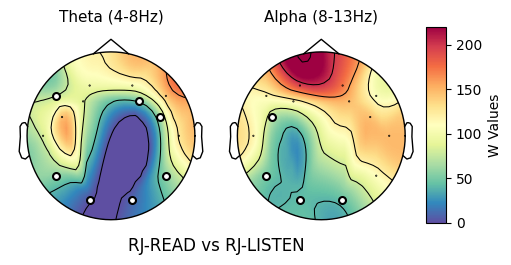

In [50]:
OUTPUT = 1

fig, axes = plt.subplots(1, 2, figsize=(5, 4), layout='constrained')

for n, band in enumerate(['theta', 'alpha']):
    vals = ss1[band]
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['W-val'].values)
    highlight_channels = pos1[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=11)
    
cbar = fig.colorbar(im, ax=axes, drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('W Values')
fig.suptitle('RJ-READ vs RJ-LISTEN', x=0.42, y=0.22)

if OUTPUT:
    plt.savefig(f'images/EEG_READLISTEN(p.05).pdf', bbox_inches='tight')
plt.show()

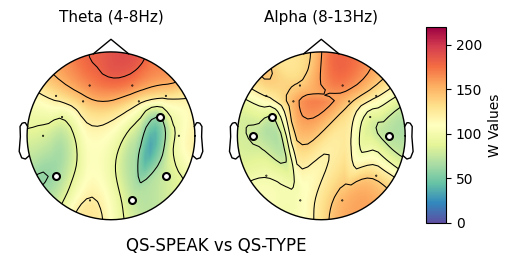

In [55]:
OUTPUT = 1

fig, axes = plt.subplots(1, 2, figsize=(5, 4), layout='constrained')

for n, band in enumerate(['theta', 'alpha',]):
    vals = ss2[band]
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['W-val'].values)
    highlight_channels = pos2[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=11)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('W Values')
fig.suptitle('QS-SPEAK vs QS-TYPE', x=0.42, y=0.22)#, x=0.45, y=0.25)

if OUTPUT:
    plt.savefig(f'images/EEG_SPEAKTYPE(p.05).pdf', bbox_inches='tight')
plt.show()